For each SNR level, let's analyse the precision & recall (mono vs beamformed)...

In [8]:
# Some useful functions / imports

import json
from pprint import pprint

def read_results_from_file(file_path):
    """Read the BirdNET detections from a file"""

    with open(file_path, 'r') as file:
        results_dict = json.load(file)

    return results_dict

# New colours
mono_col = '#18D12B'
bf_col = '#008CFF'

In [9]:
# First, for a single SNR level------------------------------------------------

expected_species_count = 30         # We should be able to detect 30 calls from each species, per file (3 calls per speaker, over 10 of the 31 speakers in the sphere)

# folder_path = "data/processed/speaker_sphere_lab_tests/0SNR"

# counts_file_path = folder_path + "/species_counts.json"

# counts_dic = read_results_from_file(counts_file_path)

# pprint(counts_dic)

def get_TP_FP_FN(species_count_dict):
    """Calculates the True Positives, True Negatives & False Negatives, from a single processed.json file
    --> Assumes that all Carolina Wren and Eurasian Blackhat detections are correct (as we're expecting them) = TP
    --> Assumes all non-CW and non-EB detections = FP (as weren't expecting other species present)   
    --> Assumes that FN = expected count - TP (i.e., all the missed detections)
    Returns: TP, FP & FN for both channels, in a dictionary"""

    # Initialise dictionary
    P_N_dict = {"mono_channel": {"TP": 0, "FP": 0, "FN": 0},
                "beamformed": {"TP": 0, "FP": 0, "FN": 0}}
    
    for channel in species_count_dict.keys():
        chan_data = species_count_dict[channel]
        # Initialise counts
        TP = 0
        FP = 0
        FN = 0
        for species in chan_data.keys():
            species_count = chan_data[species]
            if species == "Eurasian Blackcap" or species == "Carolina Wren":
                TP += species_count
            else:
                FP += species_count
        FN = expected_species_count*2 - TP          # 2 species expected, thus *2
        
        P_N_dict[channel]["TP"] = TP
        P_N_dict[channel]["FP"] = FP
        P_N_dict[channel]["FN"] = FN
    
    return P_N_dict


def calculate_precision(TP, FP):
    """Returns the precision score, to 3 dp"""

    if (TP+FP) > 0: 
        return round(TP/(TP+FP), 3)
    else:
        return 0


def calculate_recall(TP, FN):
    """Returns the recall rate, to 3 dp
    Synonym for recall = True Positive Rate (TPR)"""

    if (TP+FN) > 0: 
        return round(TP/(TP+FN), 3)
    else:
        return 0


def calculate_f05(precision, recall):
    """Returns an f0.5 score, to 3 dp"""

    if (precision + recall) > 0: 
        return round(1.25*(precision*recall)/(0.25*precision+recall), 3)
    else:
        return 0
    

def get_precision_recall_f05(P_N_dict):
    """Calculates the precision, recall rate, and f0.5 score, for each channel
    Returns: Dictionary with scores, for each channel (and maintains TP, FP & FN)"""
    
    for channel in P_N_dict.keys():
        channel_data = P_N_dict[channel]
        prec = calculate_precision(channel_data["TP"], channel_data["FP"])
        rec = calculate_recall(channel_data["TP"], channel_data["FN"])
        f05 = calculate_f05(prec, rec)
        
        P_N_dict[channel]["precision"] = prec
        P_N_dict[channel]["recall"] = rec
        P_N_dict[channel]["f05"] = f05

    return P_N_dict

# P_N_data = get_TP_FP_FN(counts_dic)
# # pprint(P_N_data)



# prec_rec_data = get_precision_recall_f05(P_N_data)
# pprint(P_N_data)


In [10]:
def extract_prec_rec(SNR_level, conf):
    """For a single species_count.json file, calculate the precision, recall & f0.5"""

    folder_path = "data/processed/speaker_sphere_lab_tests/"

    file_path = folder_path + f"{SNR_level}SNR/conf_thresholds/species_counts_{str(conf)}conf.json"

    counts_dic = read_results_from_file(file_path)

    P_N_data = get_TP_FP_FN(counts_dic)
    prec_rec_data = get_precision_recall_f05(P_N_data)

    return prec_rec_data

# SNR_prec_rec_data = {}

# for snr in snr_list:
#     SNR_prec_rec_data[snr] = extract_prec_rec(snr)

# pprint(SNR_prec_rec_data)
    

Now lets do some plotting.

Note, we have A LOT of factors...

    -f05 score
    -precision
    -recall
    -SNR
    -confidence threshold  (need to rerun the tests for different confidence levels)
    -mono vs beamformed

In [38]:
import matplotlib.pyplot as plt
import numpy as np

snr_list = ["n20", "n15", "n10", "n5", "0", "5", "10", "15", "20"]

def setup_new_plot(xlabel, ylabel, title):
    """Initialises a new matplotlib plot, with desired parameters"""
    plt.figure(figsize=(18, 10))
    plt.xlabel(xlabel, fontsize=20, labelpad=20)
    plt.ylabel(ylabel, fontsize=20, labelpad=20)
    plt.tick_params(axis="both", labelsize=16)
    plt.grid(True)


def get_lists_of_metric_conf(metric_dict, metric, conf_levels):

    mono_list = []
    bf_list = []

    for conf in conf_levels:
        conf_data = metric_dict[conf]
        mono_list.append(conf_data["mono_channel"][metric])
        bf_list.append(conf_data["beamformed"][metric])

    return mono_list, bf_list


def get_lists_of_metric(metric_dict, metric):

    mono_list = []
    bf_list = []

    for snr in snr_list:
        snr_data = metric_dict[snr]
        mono_list.append(snr_data["mono_channel"][metric])
        bf_list.append(snr_data["beamformed"][metric])

    return mono_list, bf_list

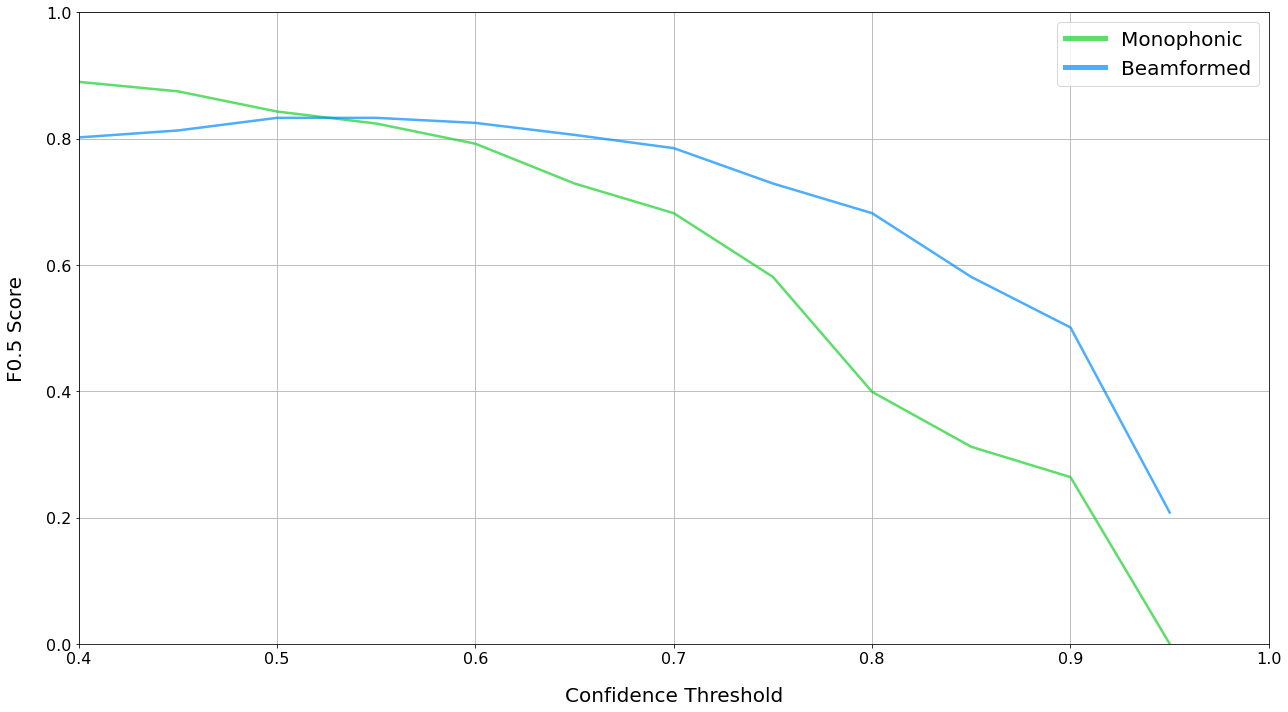

In [41]:
# First of all, for a single SNR (0 SNR - standard), let's see how confidence levels affect our predictor...

x_data = np.arange(0.4, 1, 0.05)
x_data = [round(x, 2) for x in x_data]      # Make sure all values are rounded to 2 dp

def plot_metric_data_0SNR(x_data, metric):
    SNR = 0

    if metric == "f05":
        title_metric = "F0.5 Score"
    elif metric == "recall":
        title_metric = "Recall Rate"
    else:
        title_metric = "Precision"

    # setup_new_plot("Confidence Threshold", title_metric, f"Confidence vs {title_metric} - 0 Signal to Noise Ratio - Lab Tests: Speaker Sphere")
    setup_new_plot("Confidence Threshold", title_metric, "")

    conf_prec_rec_data = {}

    for conf_min in x_data:        # Iterate through all confidence thresholds

        conf_prec_rec_data[conf_min] = extract_prec_rec(SNR, conf_min)

    y_mono, y_bf = get_lists_of_metric_conf(conf_prec_rec_data, metric, x_data)

    plt.plot(x_data, y_mono, c=mono_col, linewidth=2.5, alpha=0.7)
    plt.plot(x_data, y_bf, c=bf_col, linewidth=2.5, alpha=0.7)

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c=mono_col, label='Monophonic', alpha=0.7)
    plt.plot([], c=bf_col, label='Beamformed', alpha=0.7)
    leg = plt.legend(fontsize=20)
    leg.get_lines()[0].set_linewidth(5)
    leg.get_lines()[1].set_linewidth(5)
    plt.ylim(0, 1)
    plt.xlim(0.4, 1)
    plt.tight_layout()

    plt.show()

plot_metric_data_0SNR(x_data, "f05")


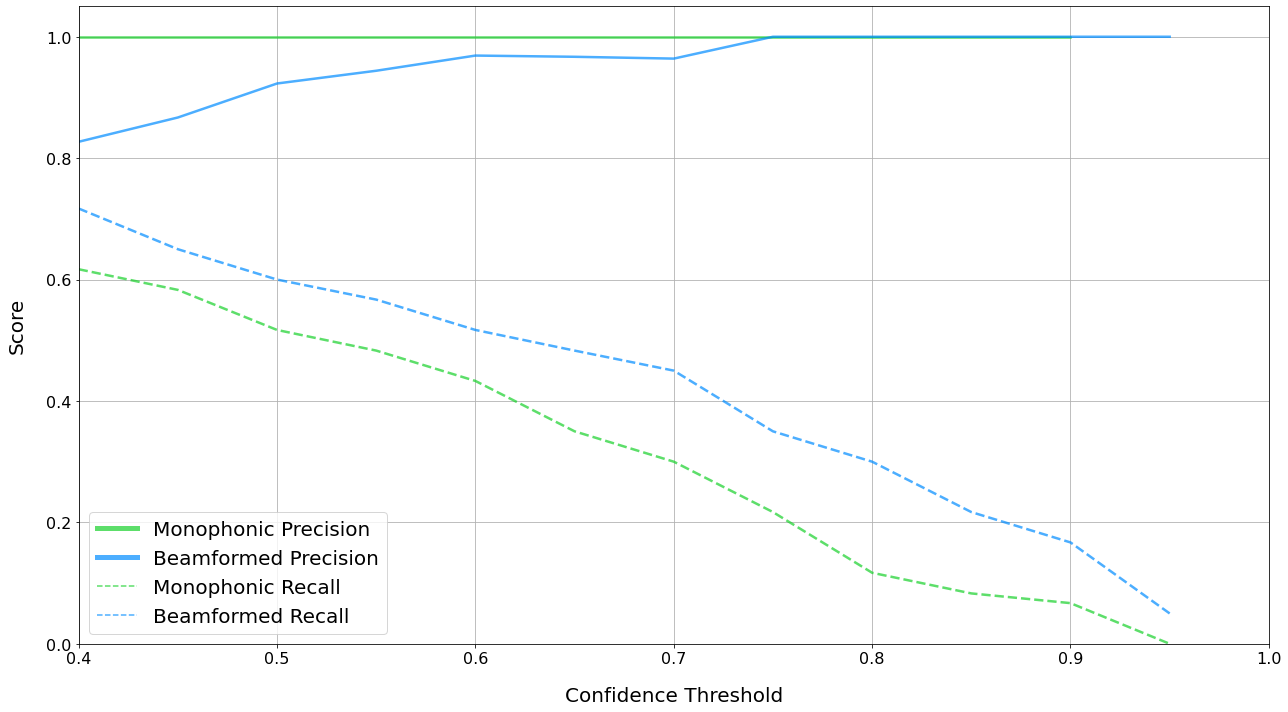

In [42]:
x_data = np.arange(0.4, 1, 0.05)
x_data = [round(x, 2) for x in x_data]      # Make sure all values are rounded to 2 dp

def plot_metric_data_0SNR(x_data):
    SNR = 0

    # setup_new_plot("Confidence Threshold", title_metric, f"Confidence vs {title_metric} - 0 Signal to Noise Ratio - Lab Tests: Speaker Sphere")
    setup_new_plot("Confidence Threshold", "Score", "")

    conf_prec_rec_data = {}

    for conf_min in x_data:        # Iterate through all confidence thresholds

        conf_prec_rec_data[conf_min] = extract_prec_rec(SNR, conf_min)

    y_mono_prec, y_bf_prec = get_lists_of_metric_conf(conf_prec_rec_data, "precision", x_data)
    y_mono_rec, y_bf_rec = get_lists_of_metric_conf(conf_prec_rec_data, "recall", x_data)

    plt.plot(x_data[:-1], y_mono_prec[:-1], c=mono_col, linewidth=2.5, alpha=0.7)   # Avoid plotting final mono prec (as N/A, no detections)
    plt.plot(x_data, y_bf_prec, c=bf_col, linewidth=2.5, alpha=0.7)
    plt.plot(x_data, y_mono_rec, c=mono_col, linewidth=2.5, alpha=0.7, linestyle="--")
    plt.plot(x_data, y_bf_rec, c=bf_col, linewidth=2.5, alpha=0.7, linestyle="--")


    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c=mono_col, label='Monophonic Precision', alpha=0.7)
    plt.plot([], c=bf_col, label='Beamformed Precision', alpha=0.7)
    plt.plot([], c=mono_col, label='Monophonic Recall', alpha=0.7, linestyle="--")
    plt.plot([], c=bf_col, label='Beamformed Recall', alpha=0.7, linestyle="--")
    leg = plt.legend(fontsize=20, loc="lower left")
    leg.get_lines()[0].set_linewidth(5)
    leg.get_lines()[1].set_linewidth(5)
    plt.ylim(0, 1.05)
    plt.xlim(0.4, 1)
    plt.tight_layout()

    plt.show()

plot_metric_data_0SNR(x_data)


From the above investigation, looking at the f05 charts, we see that there is an 'Elbow' at confidence threshold 0.7

Thus, let's compare our SNR levels, with a confidence threshold of 0.7 (good balance between recall and precision)

[0, 0.146, 0.399, 0.682, 0.714, 0.868, 0.915] [0, 0.341, 0.646, 0.785, 0.851, 0.952, 0.982] f05


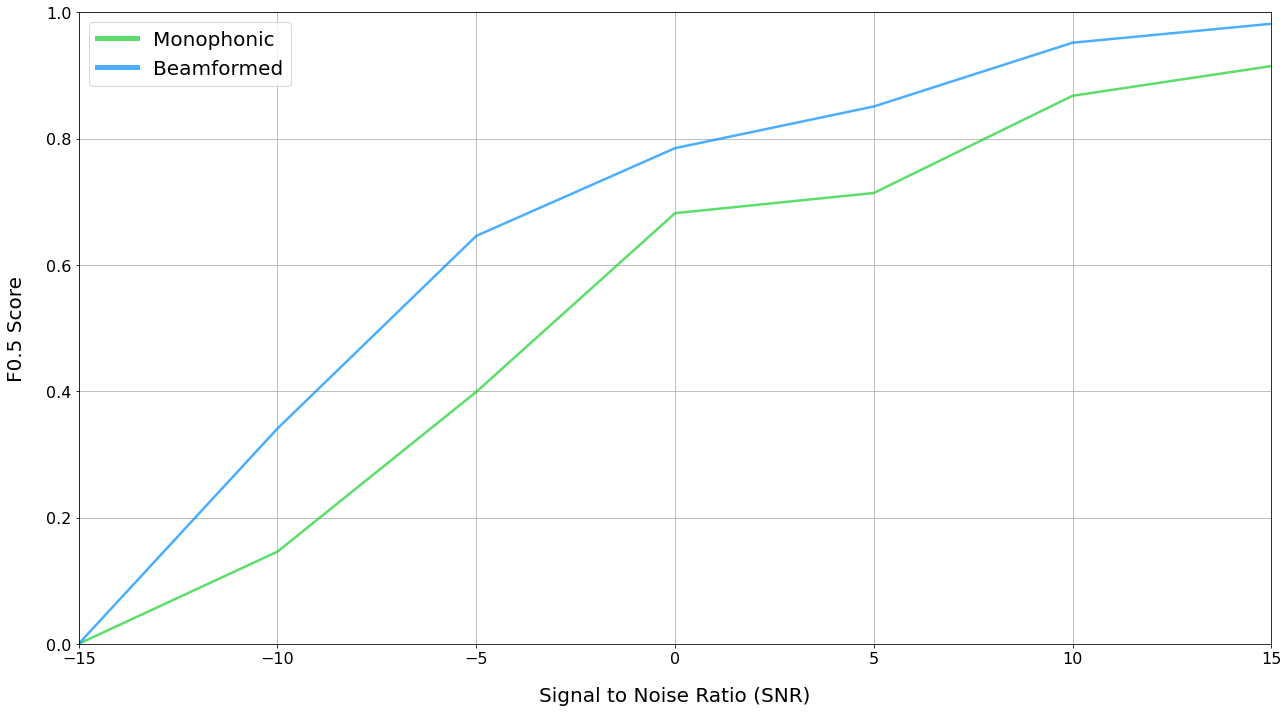

In [57]:
# F0.5 SCORE vs SNR (specify a set confidence threshold)

# snr_list = ["n20", "n15", "n10", "n5", "0", "5", "10", "15", "20"]
snr_list = ["n15", "n10", "n5", "0", "5", "10", "15"]       # Ignore n20 (no detections) and +20 (clipping in soundtrack)
x_data = np.arange(-15, 16, 5)      # SNR levels

conf_thresh = 0.7

def plot_metric_data_conf(x_data, metric):

    if metric == "f05":
        title_metric = "F0.5 Score"
    elif metric == "recall":
        title_metric = "Recall Rate"
    else:
        title_metric = "Precision"

    setup_new_plot("Signal to Noise Ratio (SNR)", title_metric, f"SNR vs {title_metric} - {str(conf_thresh)} Confidence Threshold - Lab Tests: Speaker Sphere")

    SNR_prec_rec_data = {}

    for snr in snr_list:
        SNR_prec_rec_data[snr] = extract_prec_rec(snr, conf_thresh)

    y_mono, y_bf = get_lists_of_metric(SNR_prec_rec_data, metric)

    print(y_mono, y_bf, metric)

    plt.plot(x_data, y_mono, c=mono_col, linewidth=2.5, alpha=0.7)
    plt.plot(x_data, y_bf, c=bf_col, linewidth=2.5, alpha=0.7)

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c=mono_col, label='Monophonic', alpha=0.7)
    plt.plot([], c=bf_col, label='Beamformed', alpha=0.7)
    leg = plt.legend(fontsize=20, loc="upper left")
    leg.get_lines()[0].set_linewidth(5)
    leg.get_lines()[1].set_linewidth(5)
    plt.ylim(0, 1)
    plt.xlim(-15, 15)
    plt.tight_layout()

    plt.show()

plot_metric_data_conf(x_data, "f05")

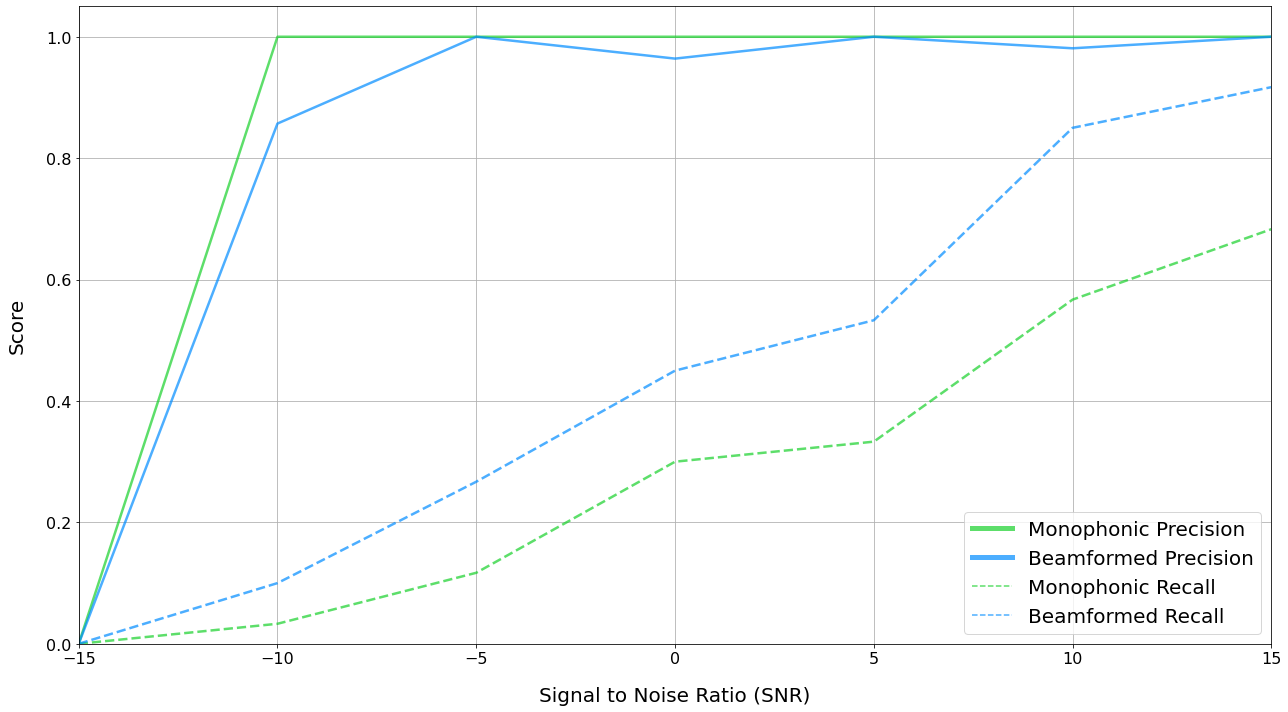

In [56]:
snr_list = ["n15", "n10", "n5", "0", "5", "10", "15"]       # Ignore n20 (no detections) and +20 (clipping in soundtrack)
x_data = np.arange(-15, 16, 5)      # SNR levels

conf_thresh = 0.7

def plot_metric_data_conf(x_data):

    setup_new_plot("Signal to Noise Ratio (SNR)", "Score", "")

    SNR_prec_rec_data = {}

    for snr in snr_list:
        SNR_prec_rec_data[snr] = extract_prec_rec(snr, conf_thresh)

    y_mono_prec, y_bf_prec = get_lists_of_metric(SNR_prec_rec_data, "precision")
    y_mono_rec, y_bf_rec = get_lists_of_metric(SNR_prec_rec_data, "recall")

    # print(y_mono, y_bf, metric)

    plt.plot(x_data, y_mono_prec, c=mono_col, linewidth=2.5, alpha=0.7)
    plt.plot(x_data, y_bf_prec, c=bf_col, linewidth=2.5, alpha=0.7)
    plt.plot(x_data, y_mono_rec, c=mono_col, linewidth=2.5, alpha=0.7, linestyle="--")
    plt.plot(x_data, y_bf_rec, c=bf_col, linewidth=2.5, alpha=0.7, linestyle="--")

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c=mono_col, label='Monophonic Precision', alpha=0.7)
    plt.plot([], c=bf_col, label='Beamformed Precision', alpha=0.7)
    plt.plot([], c=mono_col, label='Monophonic Recall', alpha=0.7, linestyle="--")
    plt.plot([], c=bf_col, label='Beamformed Recall', alpha=0.7, linestyle="--")
    leg = plt.legend(fontsize=20, loc="lower right")
    leg.get_lines()[0].set_linewidth(5)
    leg.get_lines()[1].set_linewidth(5)
    plt.ylim(0, 1.05)
    plt.xlim(-15, 15)
    plt.tight_layout()

    plt.show()

plot_metric_data_conf(x_data)
